<a href="https://colab.research.google.com/github/DheerajVarma31/UAV-Classification-using-YOLOv5/blob/main/uav-object-detection_yolov5x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import os
import random
import cv2
import matplotlib.pyplot as plt
import glob as glob
import requests
import numpy as np
import shutil



In [2]:
!nvidia-smi

Sat Jul 19 04:28:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Clone Github repo

!git clone https://github.com/iremustek/uav-object-detection-yolov5x


Cloning into 'uav-object-detection-yolov5x'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 81 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 29.71 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## Train - Test - Validation Split

In [4]:
import os
import shutil
import random
import zipfile

zip_images_path = "/content/uav-object-detection-yolov5x/data/images.zip"
zip_labels_path = "/content/uav-object-detection-yolov5x/data/labels.zip"

extracted_images_path = "/content/uav-object-detection-yolov5x/data/extracted_images"
extracted_labels_path = "/content/uav-object-detection-yolov5x/data/extracted_labels"

train_images_path = "/content/uav-object-detection-yolov5x/data/images/train"
train_labels_path = "/content/uav-object-detection-yolov5x/data/labels/train"

test_images_path = "/content/uav-object-detection-yolov5x/data/images/test"
test_labels_path = "/content/uav-object-detection-yolov5x/data/labels/test"

val_images_path = "/content/uav-object-detection-yolov5x/data/images/val"
val_labels_path = "/content/uav-object-detection-yolov5x/data/labels/val"

# Unzip the images file
with zipfile.ZipFile(zip_images_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_images_path)

# Unzip the labels file
with zipfile.ZipFile(zip_labels_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_labels_path)

# Set the paths to the extracted images and labels
original_images_path = os.path.join(extracted_images_path, "image")
original_labels_path = os.path.join(extracted_labels_path, "label")

if not os.path.exists(train_images_path):
    os.makedirs(train_images_path)
if not os.path.exists(train_labels_path):
    os.makedirs(train_labels_path)
if not os.path.exists(test_images_path):
    os.makedirs(test_images_path)
if not os.path.exists(test_labels_path):
    os.makedirs(test_labels_path)
if not os.path.exists(val_images_path):
    os.makedirs(val_images_path)
if not os.path.exists(val_labels_path):
    os.makedirs(val_labels_path)

all_images = [f for f in os.listdir(original_images_path) if f.endswith('.jpg')]
random.shuffle(all_images)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_count = int(train_ratio * len(all_images))
val_count = int(val_ratio * len(all_images))
test_count = len(all_images) - train_count - val_count

train_images = all_images[:train_count]
val_images = all_images[train_count:train_count + val_count]
test_images = all_images[train_count + val_count:]

for image in train_images:
    shutil.copy(os.path.join(original_images_path, image), os.path.join(train_images_path, image))
    shutil.copy(os.path.join(original_labels_path, image.replace('.jpg', '.txt')), os.path.join(train_labels_path, image.replace('.jpg', '.txt')))

for image in val_images:
    shutil.copy(os.path.join(original_images_path, image), os.path.join(val_images_path, image))
    shutil.copy(os.path.join(original_labels_path, image.replace('.jpg', '.txt')), os.path.join(val_labels_path, image.replace('.jpg', '.txt')))

for image in test_images:
    shutil.copy(os.path.join(original_images_path, image), os.path.join(test_images_path, image))
    shutil.copy(os.path.join(original_labels_path, image.replace('.jpg', '.txt')), os.path.join(test_labels_path, image.replace('.jpg', '.txt')))


## Visualize the datasets with their bounding box [x y width height] information


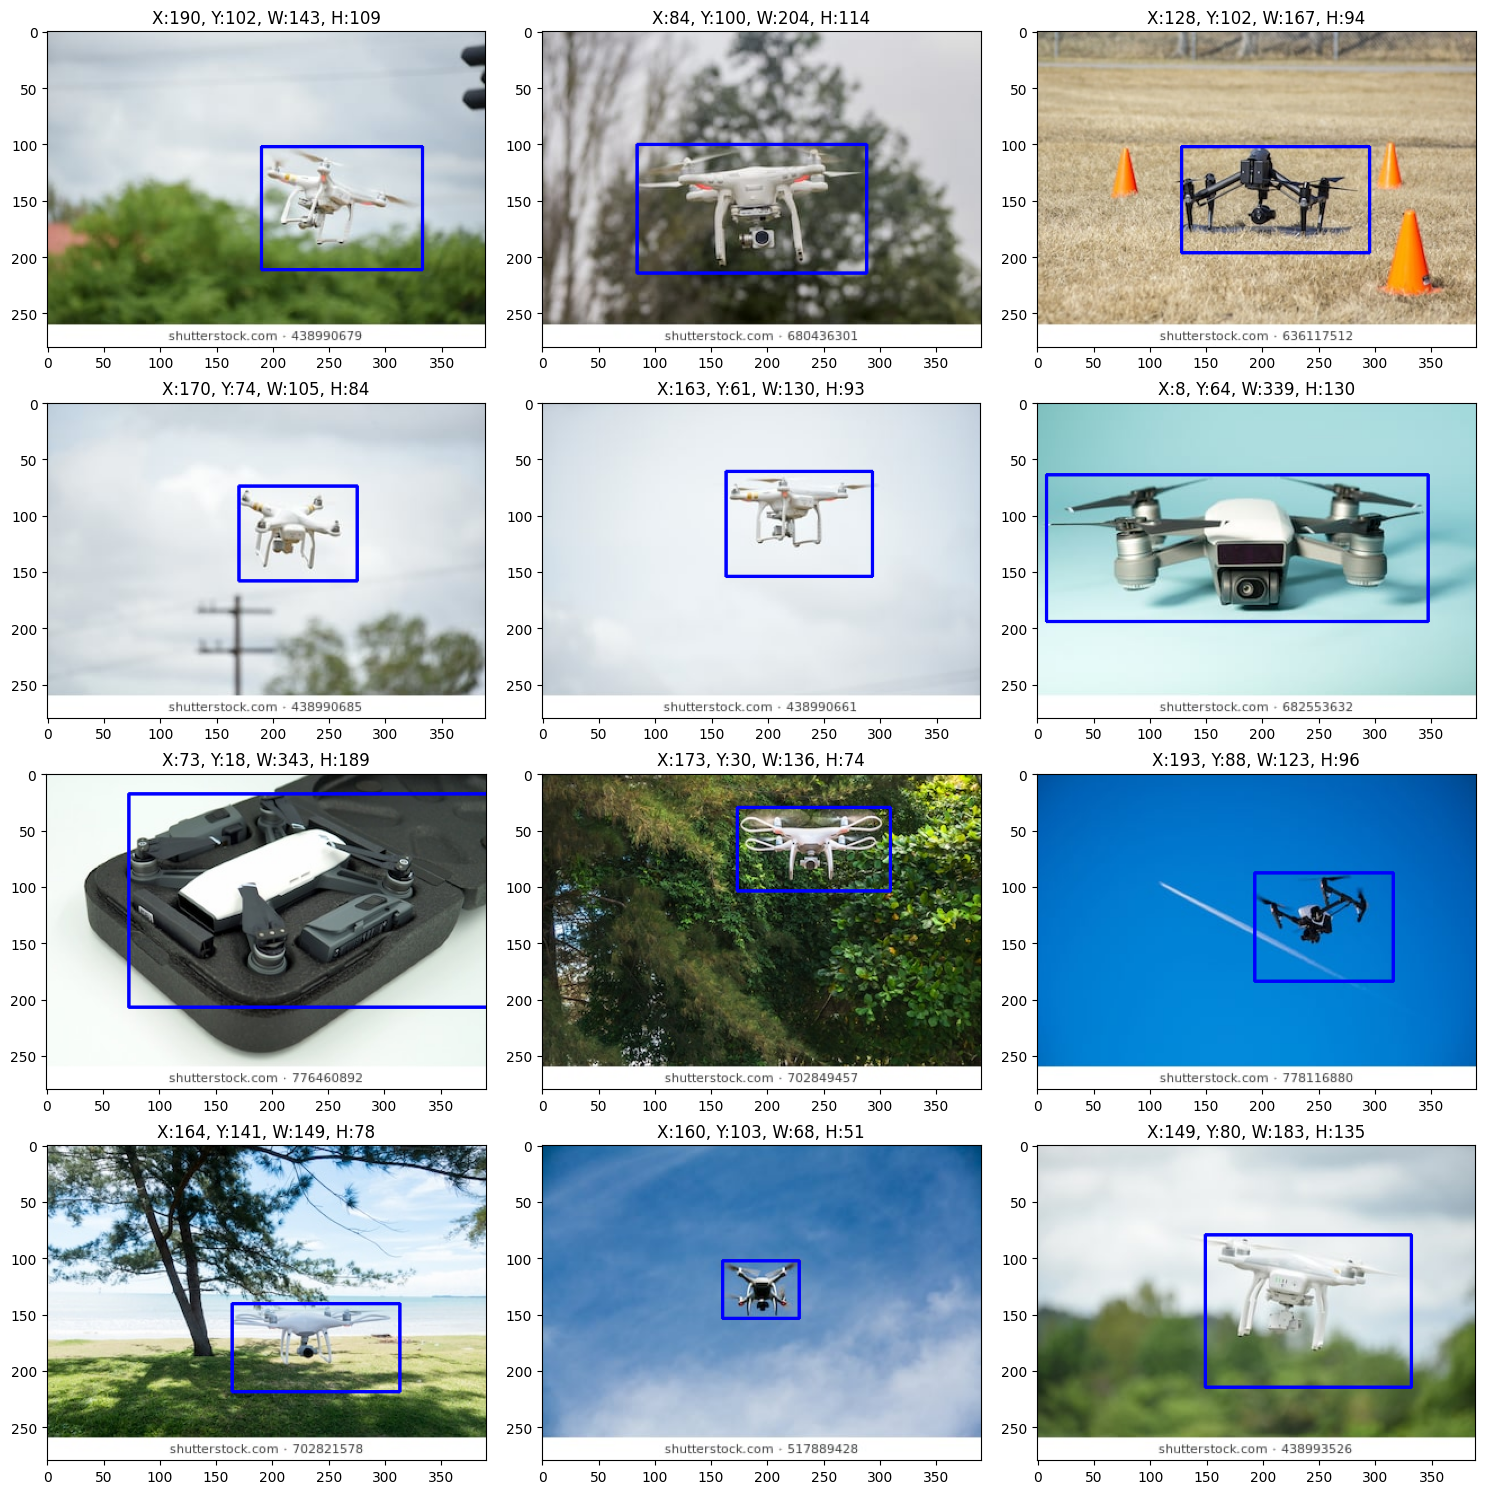

In [5]:

def visualize_bounding_boxes(img_path, label_path, number_of_images=12):
    fig, axs = plt.subplots(4, 3, figsize=(15, 15))
    axs = axs.ravel()
    img_files = [f for f in os.listdir(img_path) if f.endswith(".jpg")]
    random.shuffle(img_files)
    for i, image_file in enumerate(img_files[:number_of_images]):
        image = cv2.imread(os.path.join(img_path, image_file))
        label_file = image_file.replace(".jpg", ".txt")
        with open(os.path.join(label_path, label_file), "r") as f:
            values = f.read().strip().split(" ")
            class_id, x, y, w, h = map(float, values)
            x, y, w, h = int(x), int(y), int(w), int(h)
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[i].set_title(f"X:{x}, Y:{y}, W:{w}, H:{h}")
    plt.tight_layout()
    plt.show()

# Visualize the train dataset

img_dir = '/content/uav-object-detection-yolov5x/data/images/train'
lbl_dir = '/content/uav-object-detection-yolov5x/data/labels/train'
visualize_bounding_boxes(img_dir, lbl_dir)


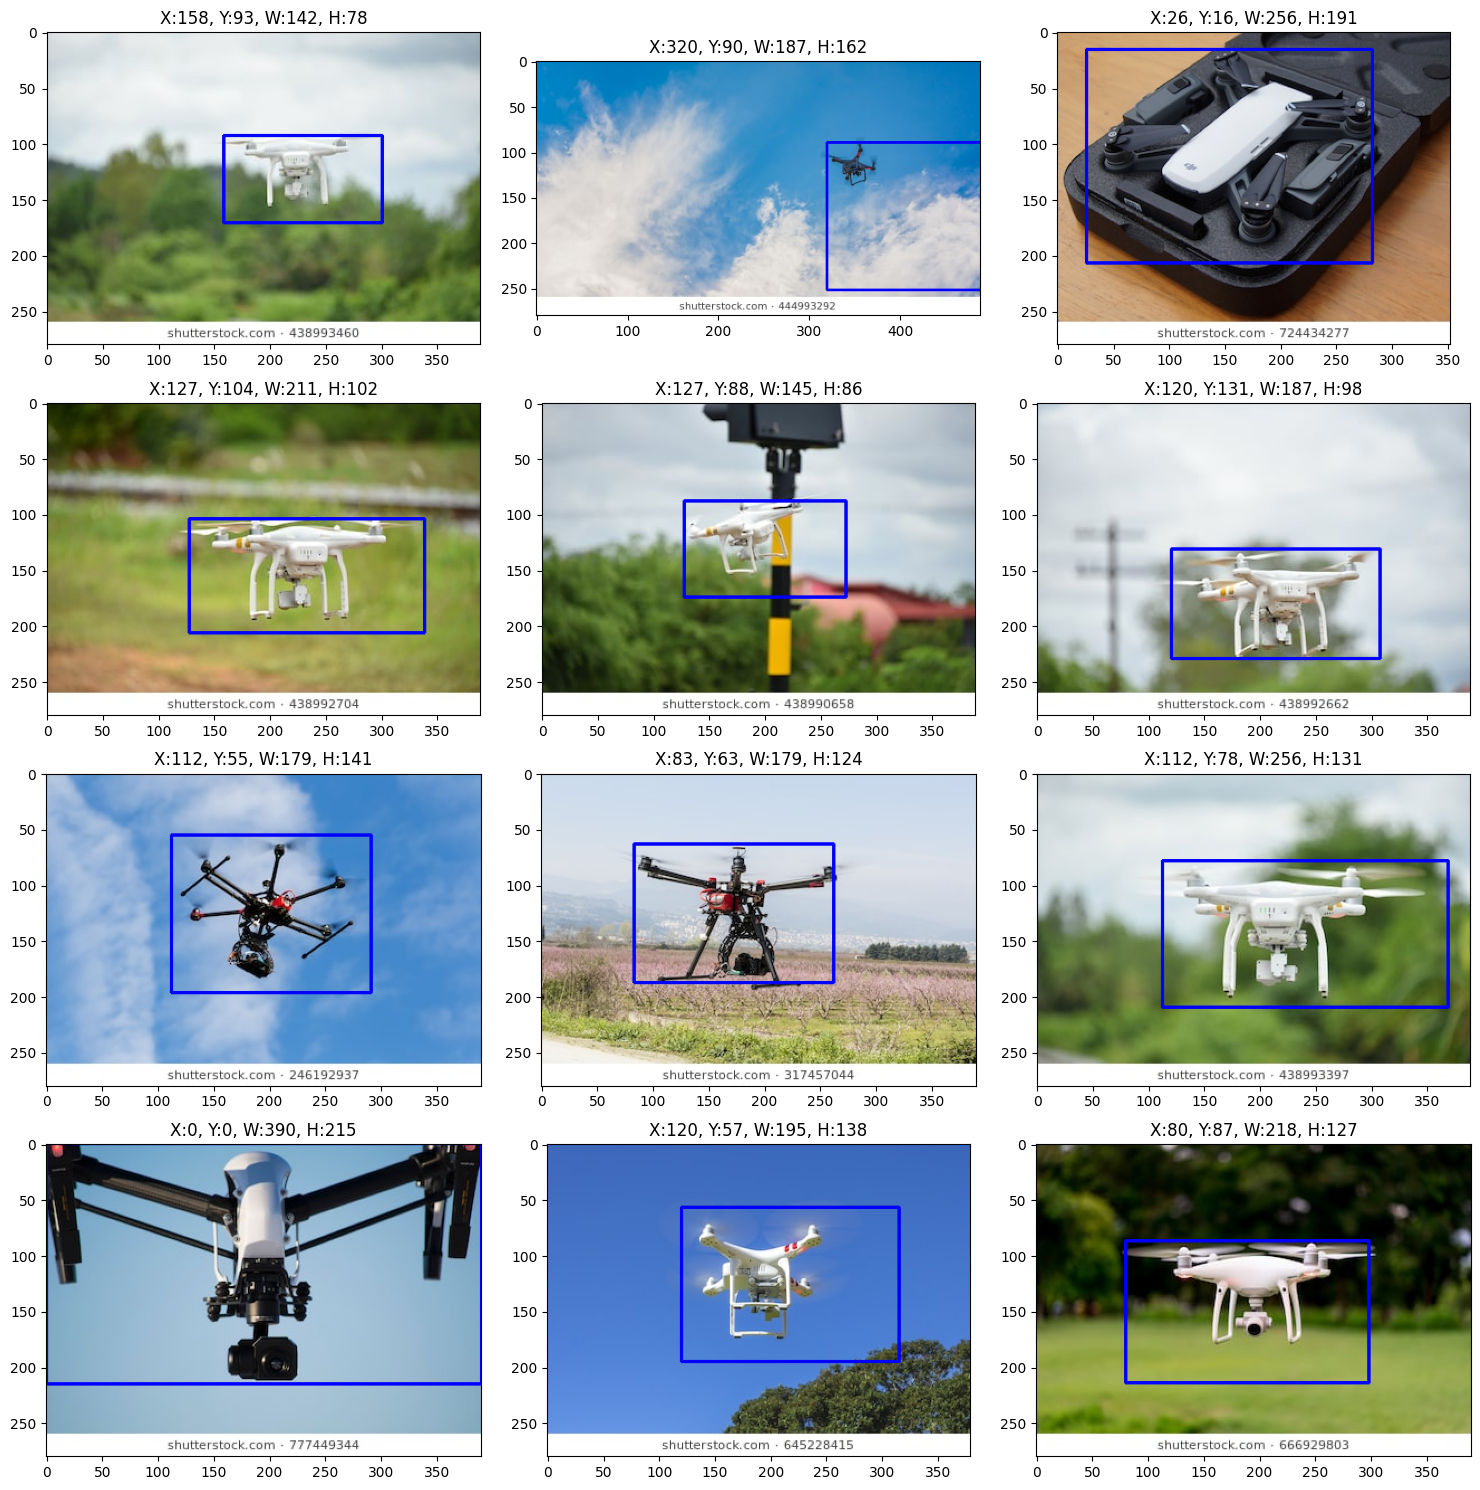

In [6]:
# Visualize the test dataset

img_dir = '/content/uav-object-detection-yolov5x/data/images/test'
lbl_dir = '/content/uav-object-detection-yolov5x/data/labels/test'
visualize_bounding_boxes(img_dir, lbl_dir)

------------------

## YOLOV5x

- YOLOv5 is an object detection algorithm for real-time object detection and classification.
-  Here, it will be used to detect the UAV in images. YOLOv5x is a specific version of the YOLOv5 algorithm that offers improved accuracy and faster inference times.

- However, in order to use **YOLOv5x**, labels need to be in a normalized (x_center, y_center, bounding box width, bounding box height) format. Therefore, label datasets for all (train, test, val) is pre-processed.

### Normalization

The normalization is done by dividing each x, y, width, and height value by the size of the image and obtained a value in the range [0,1]


In [7]:
import cv2
import os
import numpy as np

def get_image_size(image_path):
    image = cv2.imread(image_path)
    return image.shape[1], image.shape[0]

def normalize_labels(label_file_path, image_size_x, image_size_y):
    with open(label_file_path, "r") as f:
        values = f.read().strip().split(" ")
        class_id, x, y, w, h = map(float, values)

        x_center = (x + w/2) / image_size_x
        y_center = (y + h/2) / image_size_y
        w = w / image_size_x
        h = h / image_size_y

        return f"{class_id} {x_center} {y_center} {w} {h}"

def normalize_dataset(image_dir, label_dir):
    for label_file in os.listdir(label_dir):
        label_file_path = os.path.join(label_dir, label_file)

        image_file = os.path.join(image_dir, label_file.replace(".txt", ".jpg"))
        image_size_x, image_size_y = get_image_size(image_file)

        normalized_label = normalize_labels(label_file_path, image_size_x, image_size_y)

        with open(label_file_path, "w") as f:
            f.write(normalized_label)

image_dir = "/content/uav-object-detection-yolov5x/data/images/test"
label_dir = "/content/uav-object-detection-yolov5x/data/labels/test"
normalize_dataset(image_dir, label_dir)

image_dir = "/content/uav-object-detection-yolov5x/data/images/train"
label_dir = "/content/uav-object-detection-yolov5x/data/labels/train"
normalize_dataset(image_dir, label_dir)

image_dir = "/content/uav-object-detection-yolov5x/data/images/val"
label_dir = "/content/uav-object-detection-yolov5x/data/labels/val"
normalize_dataset(image_dir, label_dir)


### Setting up YOLOv5 🚀 and Creating the data.yaml File

In [8]:
!git clone https://github.com/ultralytics/yolov5  # Clone the YOLOV5 repo
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.0/112.6 GB disk)


In [9]:
# Create Yaml file

import yaml

data_yaml = {}

# Set the paths for train and test dataset for the images

data_yaml['train'] = '/content/uav-object-detection-yolov5x/data/images/train'
data_yaml['val'] = '/content/uav-object-detection-yolov5x/data/images/val'
data_yaml['nc'] = 1
data_yaml['names'] = ['uav']

# Specify the file path for the data.yaml under /content/yolov5/data
data_yaml_file = '/content/yolov5/data/data.yaml'

# Create an empty file and open it for writing
with open(data_yaml_file, 'w') as outfile:
    # Write the data_yaml dictionary to the file using YAML format
    yaml.dump(data_yaml, outfile, default_flow_style=True)

# Read and display the contents of the data.yaml file
with open(data_yaml_file, 'r') as infile:
    print(infile.read())


{names: [uav], nc: 1, train: /content/uav-object-detection-yolov5x/data/images/train,
  val: /content/uav-object-detection-yolov5x/data/images/val}



In [10]:
!pwd

# /content/yolov5

/content/yolov5


### Train YOLOv5x

In [11]:
# Train YOLOv5x with desired parameters

!python train.py --img 640 --batch 16 --epochs 150 --data data.yaml --weights yolov5x.pt --cache

2025-07-19 04:35:13.878798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752899714.126384    2544 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752899714.195271    2544 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5x.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_

### Inference on the Test Data

In [12]:
# Best weights are saved under/content/yolov5/runs/train/exp/weights as "best.pt", use them to inference on the test data

# Inference on test data

!python detect.py --weights '/content/yolov5/runs/train/exp/weights/best.pt' \
--img 640 --conf 0.25 --source '/content/uav-object-detection-yolov5x/data/images/test' \
--augment



detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/uav-object-detection-yolov5x/data/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
image 1/32 /content/uav-object-detection-yolov5x/data/images/test/09-february-2017-ufa-russia-260nw-1062076784.jpg: 480x640 2 uavs, 235.0ms
image 2/32 /content/uav-object-detection-yolov5x/data/images/test/09-february-2017-ufa-russia-260nw-1062076787.jpg: 448x64

### Visualize the Inference Results

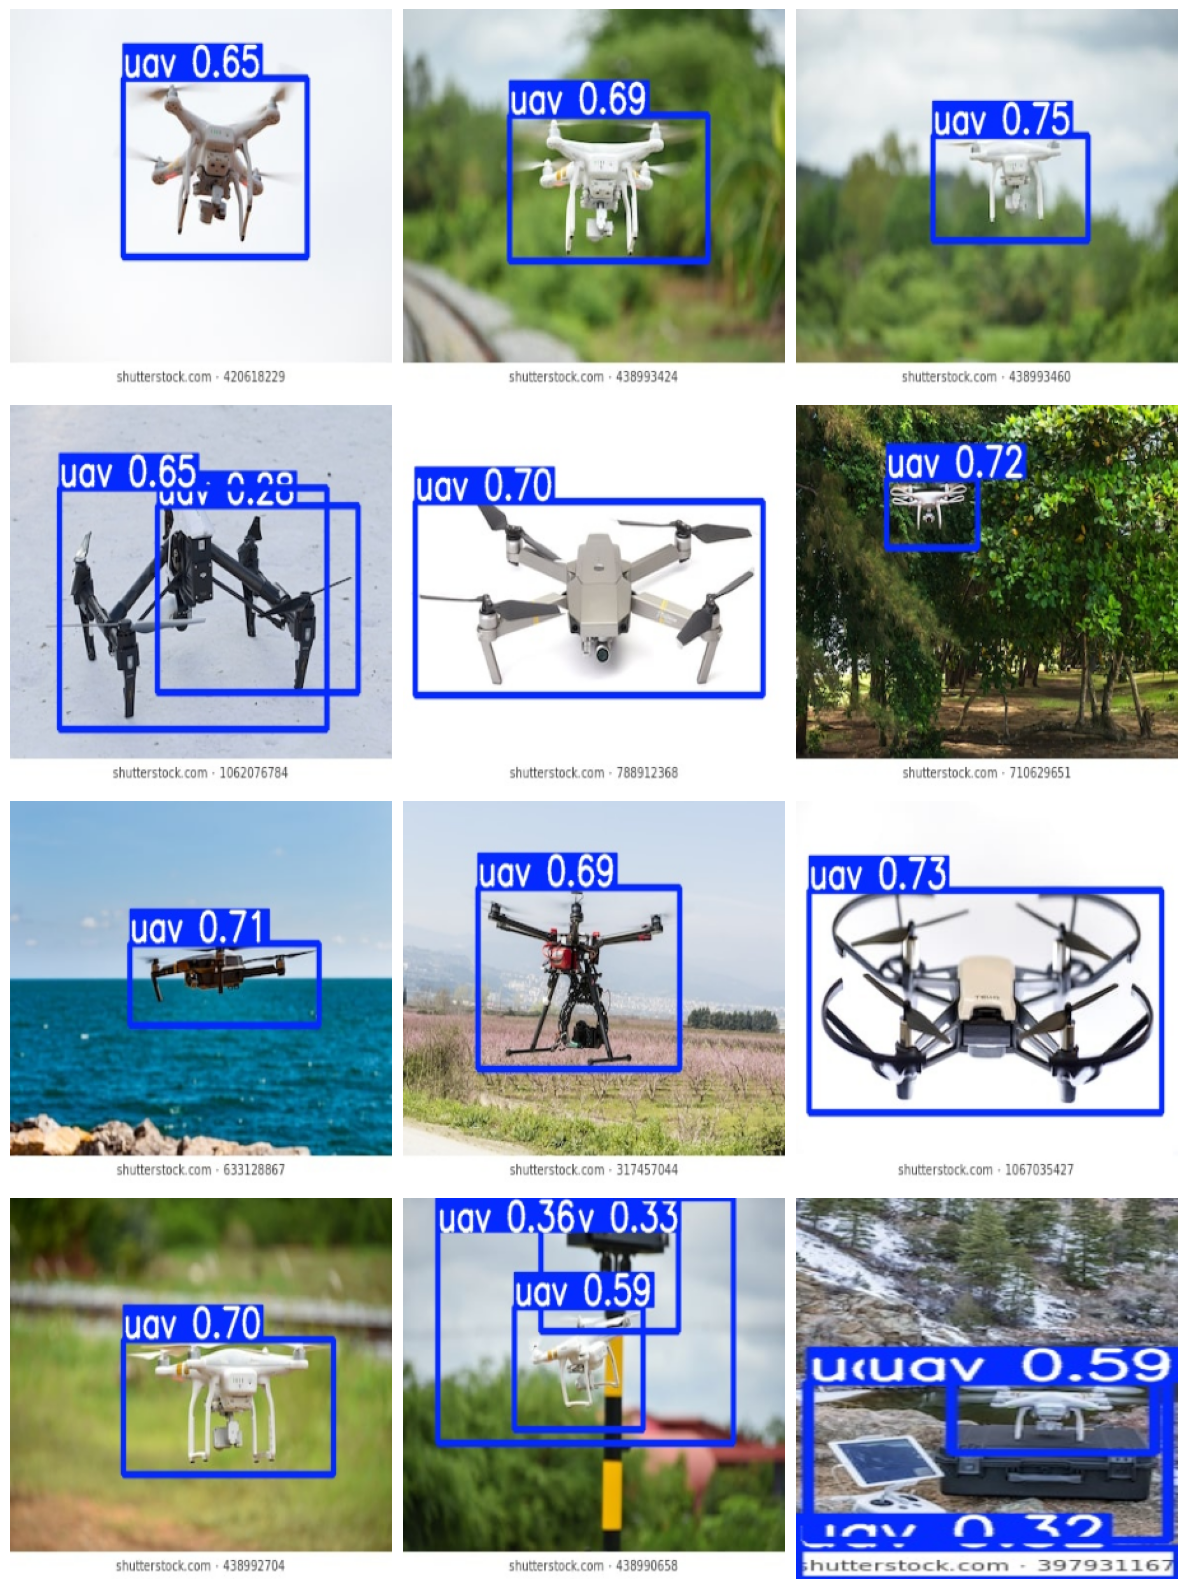

In [13]:
# Your test dataset prediction results will be stored in /yolov5/runs/detect/exp

path = '/content/yolov5/runs/detect/exp'

# Set the number of rows and columns for subplots
num_rows = 4
num_cols = 3

# Create a figure and axis for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, file in enumerate(os.listdir(path)):
    if i == num_rows * num_cols:
        break

    file_path = os.path.join(path, file)
    image = plt.imread(file_path)

    # Resize the image to a smaller size
    image_resized = cv2.resize(image, (300, 300))

    axes[i].imshow(image_resized)
    axes[i].axis('off')

# Remove any extra subplots
for j in range(num_rows * num_cols, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Clone YOLOv5 repo and install requirements
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

# Install Streamlit & pyngrok
!pip install streamlit pyngrok


Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17516 (delta 6), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17516/17516), 16.66 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (11997/11997), done.
/content/yolov5/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.7 MB/s eta 0:00:00


In [15]:
from google.colab import files
files.download('/content/yolov5/runs/train/exp/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
!ls /content/drive/MyDrive/UAV_model/


best.pt


In [88]:
import os
print(os.path.exists('/content/drive/MyDrive/UAV_model/best.pt'))  # Should print: True


True


In [75]:
!ls /content/yolov5/


app.py		 detect.py	 README.md	   utils
benchmarks.py	 export.py	 README.zh-CN.md   val.py
best.pt		 hubconf.py	 requirements.txt  yolov5
CITATION.cff	 LICENSE	 runs		   yolov5x.pt
classify	 models		 segment
CONTRIBUTING.md  __pycache__	 train.py
data		 pyproject.toml  tutorial.ipynb


In [76]:
!cp "/content/drive/MyDrive/UAV_model/best.pt" .


In [77]:
!mv best.pt /content/yolov5/
#/content/yolov5

In [78]:
from pyngrok import conf, ngrok

# Replace with your actual authtoken
conf.get_default().auth_token = "3054C3F9PcxqgHdvCFzmnwu79nJ_3EYVgobAcP7oMkjp9ZjFe"


In [90]:
import os

path = '/content/drive/MyDrive/UAV_model/best.pt'
print("Exists:", os.path.exists(path))
print("Files:", os.listdir('/content/drive/MyDrive/UAV_model'))


Exists: True
Files: ['best.pt']


In [91]:
# Mount drive (if not already)
from google.colab import drive
drive.mount('/content/drive')

# Copy the model locally
!cp /content/drive/MyDrive/UAV_model/best.pt /content/yolov5/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
!rm -rf yolov5  # clean existing
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17516 (delta 6), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17516/17516), 16.62 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (12001/12001), done.
/content/yolov5/yolov5


In [128]:
%%writefile /content/yolov5/app.py
import streamlit as st
import torch
from PIL import Image
import tempfile
import os

# Path to your trained model
MODEL_PATH = '/content/yolov5/best.pt'

if not os.path.exists(MODEL_PATH):
    st.error(f"Model not found at {MODEL_PATH}")
    st.stop()

# Load model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=MODEL_PATH, force_reload=True)

st.title("🚁 UAV Object Detection using YOLOv5")
st.write("Upload an image and let the model detect UAVs!")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as temp_file:
        temp_file.write(uploaded_file.read())
        temp_path = temp_file.name

    st.image(Image.open(temp_path), caption="Uploaded Image", use_column_width=True)

    results = model(temp_path)
    results.render()  # modifies results.ims[0] with boxes

    st.image(results.ims[0], caption="Detected Image", use_column_width=True)

    st.subheader("Detections:")
    for *box, conf, cls in results.xyxy[0]:
        label = model.names[int(cls)]
        st.write(f"🔍 {label} — Confidence: {conf:.2f}")

    os.remove(temp_path)


Overwriting /content/yolov5/app.py


In [129]:
%cd /content/yolov5
!streamlit run app.py


/content/yolov5



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.87.82.3:8502

  Stopping...
^C


In [130]:
!rm -f /root/.ngrok2/ngrok.yml
!rm -f /root/.config/ngrok/ngrok.yml


In [131]:
!ngrok config add-authtoken 3054C3F9PcxqgHdvCFzmnwu79nJ_3EYVgobAcP7oMkjp9ZjFe


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [133]:
import threading
import time
from pyngrok import ngrok

def run_streamlit():
    os.system('streamlit run app.py')

# Start Streamlit in a thread
thread = threading.Thread(target=run_streamlit)
thread.start()

# Wait for Streamlit to launch
time.sleep(5)

# Connect ngrok
public_url = ngrok.connect(8501)
print(f"🌍 Public URL: {public_url}")


🌍 Public URL: NgrokTunnel: "https://c1e6de1bc988.ngrok-free.app" -> "http://localhost:8501"
